In [1]:
import pandas as pd
import numpy as np

# For demonstration on google colab:
#!pip3 install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl 
#!pip3 install torchvision
#!pip install torch 
#!pip install fastai==0.7.0

from fastai.structured import *
from fastai.column_data import *

import warnings; warnings.simplefilter('ignore')

C:\Users\chrun\Anaconda3\envs\fastai\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
torch.cuda.is_available()

True

## Import data as pandas Dataframe

In [3]:
#change this to your folder containing the csv files
path = 'Store Item Demand Forecasting/data/'

In [4]:
train = pd.read_csv(f'{path}train.csv')
test = pd.read_csv(f'{path}test.csv')
sub = pd.read_csv(f'{path}sample_submission.csv')

In [5]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [6]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


## I chose a very clean dataset for the baseline
### Otherwise here is a good point to do data cleaning and feature engineering

In [7]:
train.isnull().sum(), train.isna().sum()

(date     0
 store    0
 item     0
 sales    0
 dtype: int64, date     0
 store    0
 item     0
 sales    0
 dtype: int64)

## Create date features
### add_datepart is a fastai function that creates date features automatically

In [8]:
for df in train, test:
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True) # format="%Y-%m-%d"

In [9]:
add_datepart(train, "date", drop=False)
add_datepart(test, "date", drop=False)
train.head()

,date,store,item,sales,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
0,2013-01-01,1,1,13,2013,1,1,1,1,1,False,True,False,True,False,True,1356998400
1,2013-01-02,1,1,11,2013,1,1,2,2,2,False,False,False,False,False,False,1357084800
2,2013-01-03,1,1,14,2013,1,1,3,3,3,False,False,False,False,False,False,1357171200
3,2013-01-04,1,1,13,2013,1,1,4,4,4,False,False,False,False,False,False,1357257600
4,2013-01-05,1,1,10,2013,1,1,5,5,5,False,False,False,False,False,False,1357344000


## Split columns into categorical/numerical for embedding matrices

In [10]:
target = 'sales'

excluded_features = ['sales', 'date', 'Elapsed']

cat_vars = [ _f for _f in train.columns if (_f not in excluded_features)]
cat_vars

['store',
 'item',
 'Year',
 'Month',
 'Week',
 'Day',
 'Dayofweek',
 'Dayofyear',
 'Is_month_end',
 'Is_month_start',
 'Is_quarter_end',
 'Is_quarter_start',
 'Is_year_end',
 'Is_year_start']

In [11]:
for v in cat_vars: train[v] = train[v].astype('category').cat.as_ordered()
apply_cats(test, train)

In [12]:
train[target] = train[target].fillna(0).astype('float32')
test['sales'] = 0
test[target] = test[target].astype('float32')

## Sort & set index by date (to get time series) and factorize dataframes with proc_df

In [13]:
train = train.sort_values('date').set_index('date')
test = test.sort_values('date').set_index('date')

df, y, nas, mapper = proc_df(train, 'sales', do_scale=True)

In [14]:

df_test, _, nas, mapper = proc_df(test, 'sales', do_scale=True, skip_flds=['id'], mapper=mapper, na_dict=nas)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 15 columns):
store               913000 non-null int8
item                913000 non-null int8
Year                913000 non-null int8
Month               913000 non-null int8
Week                913000 non-null int8
Day                 913000 non-null int8
Dayofweek           913000 non-null int8
Dayofyear           913000 non-null int16
Is_month_end        913000 non-null int8
Is_month_start      913000 non-null int8
Is_quarter_end      913000 non-null int8
Is_quarter_start    913000 non-null int8
Is_year_end         913000 non-null int8
Is_year_start       913000 non-null int8
Elapsed             913000 non-null float64
dtypes: float64(1), int16(1), int8(13)
memory usage: 47.0 MB


In [16]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 45000 entries, 2018-01-01 to 2018-03-31
Data columns (total 15 columns):
store               45000 non-null int8
item                45000 non-null int8
Year                45000 non-null int8
Month               45000 non-null int8
Week                45000 non-null int8
Day                 45000 non-null int8
Dayofweek           45000 non-null int8
Dayofyear           45000 non-null int16
Is_month_end        45000 non-null int8
Is_month_start      45000 non-null int8
Is_quarter_end      45000 non-null int8
Is_quarter_start    45000 non-null int8
Is_year_end         45000 non-null int8
Is_year_start       45000 non-null int8
Elapsed             45000 non-null float64
dtypes: float64(1), int16(1), int8(13)
memory usage: 2.6 MB


## Create Validation set (3 months like test set)

In [17]:
val_idx = np.flatnonzero((df.index<datetime.datetime(2018,1,1)) & (df.index>=datetime.datetime(2017,10,1)))

## Prepare Metric and Target Variable

In [18]:
def inv_y(a): return np.exp(a) - 1

def smape(y_pred, targ):
    targ = inv_y(targ)
    pred = inv_y(y_pred)
    ape = 2 * np.abs(pred - targ) / (np.abs(pred) + np.abs(targ))
    return ape.mean() 

yl = np.log1p(y)
max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

## Create ColumnarModelData (fast.ai connection to pytorch)

In [19]:
md = ColumnarModelData.from_data_frame(path, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=256, test_df=df_test)

## Calculate embedding matrix size for each categorical column

In [20]:
cat_sz = [(c, len(train[c].cat.categories)+1) for c in cat_vars]
cat_sz

[('store', 11),
 ('item', 51),
 ('Year', 6),
 ('Month', 13),
 ('Week', 54),
 ('Day', 32),
 ('Dayofweek', 8),
 ('Dayofyear', 367),
 ('Is_month_end', 3),
 ('Is_month_start', 3),
 ('Is_quarter_end', 3),
 ('Is_quarter_start', 3),
 ('Is_year_end', 3),
 ('Is_year_start', 3)]

In [21]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]
emb_szs

[(11, 6),
 (51, 26),
 (6, 3),
 (13, 7),
 (54, 27),
 (32, 16),
 (8, 4),
 (367, 50),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2),
 (3, 2)]

## Set pytorch model parameters 

In [22]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

## lr_find is a way to get a good learning rate 
### (take lr at the point it stops decreasing the loss)

In [23]:
lr = 1e-3
m.lr_find(end_lr = 1e-3)

epoch      trn_loss   val_loss                                                                                         
    0      0.031148   0.029559  



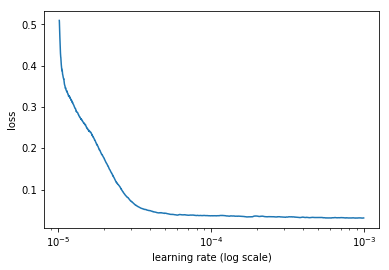

In [24]:
m.sched.plot()

In [25]:
lr = 2e-5 #1e-5

## Fitting the model

In [26]:
m.fit(lr, 1, cycle_len=3, metrics=[smape])

epoch      trn_loss   val_loss   smape                                                                                 
    0      0.036609   0.028372   0.132329  
    1      0.033306   0.026464   0.127767                                                                              
    2      0.033104   0.02628    0.127319                                                                              



[0.026280424126464388, 0.12731917667388917]

In [27]:
m.save('item_revenue_E3')

In [28]:
m.fit(lr, 2, cycle_len=2, cycle_mult=3, metrics=[smape])

epoch      trn_loss   val_loss   smape                                                                                 
    0      0.031813   0.025728   0.126074  
    1      0.03145    0.025577   0.125834                                                                              
    2      0.029503   0.025326   0.12481                                                                               
    3      0.029902   0.025267   0.124856                                                                              
    4      0.029392   0.025131   0.124795                                                                              
    5      0.028354   0.025099   0.124374                                                                              
    6      0.029235   0.025067   0.124719                                                                              
    7      0.029087   0.025051   0.124558                                                                           

[0.02505077553378499, 0.12455774027886599]

In [29]:
m.save('item_revenue_3E8ER')

In [30]:
m.fit(lr, 2, cycle_len=2, cycle_mult=2, metrics=[smape])

epoch      trn_loss   val_loss   smape                                                                                 
    0      0.029176   0.025135   0.125176  
    1      0.028489   0.02496    0.124296                                                                              
    2      0.028828   0.024999   0.124591                                                                              
    3      0.028367   0.02505    0.124696                                                                              
    4      0.028128   0.024849   0.123716                                                                              
    5      0.028354   0.02487    0.124084                                                                              



[0.024870385412936624, 0.12408423715052397]

In [31]:
m.save('item_revenue_3E8ER6ER')

In [32]:
x,y=m.predict_with_targs()

In [33]:
smape(x, y)

0.12408424

In [34]:
pred_test=m.predict(True)
pred_test=np.expm1(pred_test)
pred_test.mean()

47.50325

In [35]:
sub['sales'] = pred_test
sub.to_csv(f'{path}sub_fastai_baseline.csv', index=False)